Notebook author: Makar Shevchenko B20-DS-01

# Model Training and Visualization

Execute this notebook in Google Colab

In this notebook I train several text detoxification models on ParaNMT-detox corpus and visualize the results. I processed the corpus in `1.0-data-exploration-and-preprocessing.ipynb`. I tried two families of models: dictionary-based and transformer-based. Dictionary-based models include one, that removes toxic tokens, and two replacing by synonims: WordNet and RoBERTa-based. I implemented transformer-based model from scratch using custom embeddings and RNNs. Transformer-based model achieved the best results on validation set: 0.25 BLEU.

## Imports

Import libraries utilized next

In [1]:
!pip install wget
!pip install transformers

import os
import re
import nltk
import wget
import time
import math
import torch
import random
import unicodedata
import numpy as np
import pandas as pd
from io import open
from tqdm import tqdm
import torch.nn as nn
from torch import optim
from zipfile import ZipFile
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from transformers import pipeline
import matplotlib.ticker as ticker
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from torchtext.data.metrics import bleu_score
from sklearn.model_selection import train_test_split
from __future__ import unicode_literals, print_function, division
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

nltk.download('punkt')
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a306ee9a871086f02448d994826a83061542cddc3a36784f8684db52f6fc3fc4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 13.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Configuration

Define the parameters for notebook behavior

In [2]:
TSV_PATH = "./filtered.tsv"
URL = "https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip"
ZIP_SAVE_PATH = "./filtered.zip"
TSV_SAVE_DIR = "."
ENCODER_CKPT_PATH = "./encoder_best.pt"
DECODER_CKPT_PATH = "./decoder_best.pt"
ATTN_ENCODER_CKPT_PATH = "./attn_encoder_best.pt"
ATTN_DECODER_CKPT_PATH = "./attn_decoder_best.pt"
TRANSF_TRAIN_MAX_LENGTH = 15
VALIDATION_RATIO = 0.01

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data reading and preprocessing

In this step I load ParaNMT-detox corpus and prepare the data for the model training

### Collect initial data

Load the dataset

In [3]:
if not os.path.isfile(TSV_PATH):
    wget.download(URL, ZIP_SAVE_PATH)
    with ZipFile(ZIP_SAVE_PATH, "r") as zip_file:
        zip_file.extractall(TSV_SAVE_DIR)
    os.remove(ZIP_SAVE_PATH)
dataset = pd.read_csv(TSV_PATH, sep="\t", index_col=0)

## Data Preprocessing

In this step I get rid of duplicates and flip the entries where the translation is more toxic than reference

### Data Cleaning

Remove duplicates

In [4]:
print(dataset.shape)
dataset.drop_duplicates(["reference", "translation"], inplace=True)
print(dataset.shape)

(577777, 6)
(558133, 6)


### Deal with Inconsistent data

Remove pairs where translation is more toxic than reference

In [5]:
print(dataset.shape)
dataset.drop(dataset[dataset["trn_tox"] > dataset["ref_tox"]].index, inplace=True)
print(dataset.shape)
dataset.drop(dataset[dataset["ref_tox"] < 0.5].index, inplace=True)
print(dataset.shape)
dataset.drop(dataset[dataset["trn_tox"] > 0.5].index, inplace=True)
print(dataset.shape)

(558133, 6)
(307725, 6)
(307725, 6)
(307725, 6)


### Train and Test Split

Split the data set on parts for training and evaluation

In [6]:
train_split, val_split = train_test_split(dataset.index, test_size=VALIDATION_RATIO, random_state=420)
train = dataset[dataset.index.isin(train_split)]
val = dataset[dataset.index.isin(val_split)]

## Modeling

In this step I define model architecture, test design, and train the model.

### Generate Test Design

Implement base class for detexification models and assessment function. The assesment function prints a model results on several samples and computes BiLingual Evaluation Understudy (BLEU) score on validation set. I test the function on a dummy model that do not change input sequence.

The reason for choosing BLEU score is its appropriateness for the task, that is seq2seq translation and popularity in research community. The key idea behind BLEU is computing number of matching substrings between reference answers and candidates, thus this metric is tolerant for few words confusion and even skipping.

In [7]:
class DetoxModel:
    def __init__(self, *args, **kwargs):
        pass

    def detox(self, sentence: list[str]) -> list[str]:
        raise NotImplementedError

references_corpus = [[word_tokenize(seq)] for seq in val["translation"]]

def assess_model(model: DetoxModel, samples: int = 3, silent=False) -> float:
    if not silent:
        for index, row in val[:samples].iterrows():
            ref = word_tokenize(row['reference'])
            tran = word_tokenize(row['translation'])
            print(f"Reference: \"{ref}\"")
            print(f"Detoxed: \"{model.detox(ref)}\"")
            print(f"Translation: \"{tran}\"\n")
    candidate_corpus = [model.detox(word_tokenize(seq)) for seq in tqdm(val["reference"])]
    bleu = bleu_score(candidate_corpus, references_corpus)
    if not silent:
        print(f"BLEU: {bleu}")
    return bleu

# try evaluation
class DummyDetoxModel(DetoxModel):
    def detox(self, sentence: list[str]) -> list[str]:
        return sentence

assess_model(DummyDetoxModel())

Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Translation: "['the', 'Goddam', 'Variety', 'printed', '

100%|██████████| 3078/3078 [00:00<00:00, 7244.72it/s]


BLEU: 0.231421560049057


0.231421560049057

### Dictionary-based Detection and Removal of Toxic Words

Next, I implement the model based on removal of toxic words. They model is detected as toxic if it appears in the set of toxic words. The set of toxic words is computed from the training set. A word is considered toxic if more than half of phrases where the word appears are toxic, i.e. toxicity value of the sentence is > 0.5. Toxic words are additionally filtered by the minumal number of appearences in toxic phrases - 100, that is experimentally found threshold.

#### Model Build

The set of toxic words

In [8]:
words_cnt = Counter((word
                     for seq in train["reference"]
                     for word in set(word_tokenize(seq))))
words_cnt += Counter((word
                      for seq in train["translation"]
                      for word in set(word_tokenize(seq))))
tox_words_cnt = Counter((word
                         for seq in train["reference"][train["ref_tox"] > 0.5]
                         for word in set(word_tokenize(seq))))
tox_words_cnt += Counter((word
                          for seq in train["translation"][train["trn_tox"] > 0.5]
                          for word in set(word_tokenize(seq))))
words_toxicity = {word: cnt / words_cnt[word] for word, cnt in tox_words_cnt.items() if cnt > 100}
toxic_words = {word for word, toxicity in words_toxicity.items() if toxicity > 0.5}
print(len(toxic_words))
list(toxic_words)[:10]

1285


['that',
 'bitch',
 'neither',
 'hide',
 'Nick',
 'month',
 'hammer',
 'day',
 't',
 'Go']

The model transforming algorithm. I also define a general class for replacement-based detox models for code compactness

In [9]:
class MapDetoxModel(DetoxModel):
    def _is_toxic(self, token: str) -> bool:
        return token in toxic_words

    def _neutralize(self, token: str) -> str | None:
        raise NotImplementedError

    def detox(self, sentence: list[str]) -> list[str]:
        corrected = []
        for token in sentence:
            if self._is_toxic(token):
                replacement = self._neutralize(token)
                if replacement:
                    token = replacement
                else:
                    continue
            corrected.append(token)
        return corrected

class RemoveDetoxModel(MapDetoxModel):
    def _neutralize(self, token: str) -> str | None:
        return None

#### Assess Model

Print results on three samples and compute BLEU score

In [10]:
rm_model = RemoveDetoxModel()
rm_bleu = assess_model(rm_model)

Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "["'re", 'have', 'the', 'sickness', 'elites', 'have', 'throughout', 'in', 'literal', 'and', 'in', 'cases', 'figurative', 'ivory', 'towers']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['Variety', 'to', 'print', 'the', 'before', 'I', 'the', 'rights']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notgoing', 'to', 'kill', 'you', '?']"
De

100%|██████████| 3078/3078 [00:00<00:00, 4539.66it/s]


BLEU: 0.08477326112878693


The dummy detoxer has better BLEU score

### Dictionary-based Detection of Toxic Words and Replacement by WordNet Synonyms

The following model modify toxic words as well as previous model, but changes the words by their synonyms from WordNet

#### Model Build

In [11]:
class WnSynDetoxModel(MapDetoxModel):
    def _neutralize(self, token: str) -> str | None:
        synonyms = wn.synonyms(token)
        for syn_cat in synonyms:
            if syn_cat:
                return syn_cat[0]

#### Assess Model

Print results on three samples and compute BLEU score

In [12]:
wn_syn_model = WnSynDetoxModel()
wn_syn_bleu = assess_model(wn_syn_model)

Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "["'re", 'chesty', 'have', 'the', 'sickness', 'elites', 'have', 'have', 'throughout', 'account', 'in', 'literal', 'and', 'in', 'about', 'cases', 'figurative', 'ivory', 'towers']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['damn', 'Variety', 'have', 'to', 'print', 'the', 'narration', 'before', 'I', 'acquire', 'the', 'rights']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '

100%|██████████| 3078/3078 [00:01<00:00, 2570.84it/s]


BLEU: 0.0946853252415241


The BLEU score of the model is sligtly better than score of the previous, but still worse than dummy detoxer

### Dictionary-based Detection of Toxic Words and Replacement by RoBERTa Synonyms

The following model works identically as previous, but the neutral synonims are generated with pretrained transformer-based model RoBERTa that take context into account

#### Model Build

In [13]:
class BertSynDetoxModel(MapDetoxModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlm = pipeline('fill-mask')

    def detox(self, sentence: list[str]) -> list[str]:
        corrected = []
        masked_inds = []
        for i, token in enumerate(sentence):
            if self._is_toxic(token):
                token = self.mlm.tokenizer.mask_token
                masked_inds.append(i)
            corrected.append(token)
        if masked_inds:
            result = self.mlm(" ".join(corrected))
            for i, replacements in zip(masked_inds, result):
                if isinstance(replacements, list):
                    corrected[i] = replacements[0]["token_str"]
                else:
                    corrected[i] = replacements["token_str"]
        return corrected

#### Assess Model

Print results on three samples and compute BLEU score

In [14]:
bert_syn_model = BertSynDetoxModel()
bert_syn_bleu = assess_model(bert_syn_model)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['These', "'re", 'bel', "'", "'", 'have', 'the', 'sickness', ' that', 'elites', 'have', ' esp', 'oused', 'throughout', ' Europe', 'in', ' literal', 'literal', ' representations', 'and', 'in', ' some', 'cases', 'figurative', ' literal', 'ivory', 'towers', ".'"]"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "[' contacted', 'Variety', ' permission', 'to', 'print', 'the', ' article', 'before', 'I', ' acquired', 'the', 'rights', '.']"
Transla

100%|██████████| 3078/3078 [06:38<00:00,  7.72it/s]


BLEU: 0.08951501548290253


### GRU-based transformer

Next, I implement a seq2seq Model consisting of encoder and decoder. I chose pretrained encoder - DistilBERT since this model accumulates hundreds of hours of training on the data from different domains, so the embeddings should be relevant.

#### Model Build

The pipeline is done accordingly to the PyTorch guide https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Define an interface for the model to evaluate it with BLEU score

In [15]:
class TransformerDetoxModel(DetoxModel):
    def __init__(self, encoder, decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def detox(self, sentence: list[str]) -> list[str]:
        sentence = normalizeString(" ".join(sentence))
        self.encoder.eval()
        self.decoder.eval()
        output_words, _ = evaluate(self.encoder, self.decoder, sentence, input_lang, output_lang)
        return output_words[:-1]

Write a vocab

In [16]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in word_tokenize(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Text normalizers

In [17]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Input/output parser, that train vocabs and collect train pairs

In [18]:
def readLangs(lang1, lang2, reverse=False, data=train):
    # Split every line into pairs and normalize
    pairs = [[normalizeString(l[lang1]), normalizeString(l[lang2])] for i, l in data.iterrows()]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Data filters for training speedup

In [19]:
def filterPair(p):
    return len(word_tokenize(p[0])) < TRANSF_TRAIN_MAX_LENGTH and \
        len(word_tokenize(p[1])) < TRANSF_TRAIN_MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Dataset parser

In [20]:
def prepareData(lang1, lang2, reverse=False, data=train):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse, data)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData("reference", "translation", False)
print(random.choice(pairs))

Read 304647 sentence pairs
Trimmed to 223970 sentence pairs
Counting words...
Counted words:
reference 39902
translation 34190
['and i ve gotta stop bitching ?', 'and i have to stop complaining ?']


Define encoder

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Define decoder

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(TRANSF_TRAIN_MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

Input preprocessors

In [23]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word) or lang.word2index["the"] for word in word_tokenize(sentence)]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData("reference", "translation", False)

    n = len(pairs)
    input_ids = np.zeros((n, TRANSF_TRAIN_MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, TRANSF_TRAIN_MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

Epoch train loop

In [24]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    total_loss = 0
    for data in tqdm(dataloader):
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Epoch validation loop

In [25]:
def val_one_epoch(
    encoder,
    decoder,
    epoch_num=-1,
    best_so_far=0.0,
    encoder_ckpt_path=ENCODER_CKPT_PATH,
    decoder_ckpt_path=DECODER_CKPT_PATH
):
    print(f"Epoch {epoch_num}: val")
    metric = assess_model(TransformerDetoxModel(encoder, decoder))
    if metric > best_so_far:
        torch.save(encoder.state_dict(), encoder_ckpt_path)
        torch.save(decoder.state_dict(), decoder_ckpt_path)
        best_so_far = metric

    return metric, best_so_far

Utilities for train monitoring

In [26]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Utility for visualizations

In [27]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Main train loop

In [28]:
def train_fun(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
              encoder_ckpt_path=ENCODER_CKPT_PATH, decoder_ckpt_path=DECODER_CKPT_PATH):
    start = time.time()
    best_so_far = -1.0
    losses = []
    metrics = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                    epoch, epoch / n_epochs * 100, loss))
        metric, best_so_far = val_one_epoch(encoder, decoder, epoch, best_so_far, encoder_ckpt_path, decoder_ckpt_path)
        metrics.append(metric)
        losses.append(loss)

    return losses, metrics

Predict function

In [29]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Prediction of few random samples from training set

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Initialize the model and train

In [31]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

losses, metrics = train_fun(train_dataloader, encoder, decoder, 5, encoder_ckpt_path=ENCODER_CKPT_PATH, decoder_ckpt_path=DECODER_CKPT_PATH)

Read 304647 sentence pairs
Trimmed to 223970 sentence pairs
Counting words...
Counted words:
reference 39902
translation 34190


100%|██████████| 7000/7000 [03:26<00:00, 33.96it/s]


3m 26s (- 13m 44s) (1 20%) 2.2987
Epoch 1: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'only', 'one', 'who', 's', 'got', 'a', 'couple', 'of', 'the', 'other', 'people']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['i', 've', 'had', 'to', 'get', 'the', 'last', 'time', 'to', 'the', 'ground', '!']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notgoing', 't

100%|██████████| 3078/3078 [00:22<00:00, 137.60it/s]


BLEU: 0.024870469976541597


100%|██████████| 7000/7000 [03:23<00:00, 34.43it/s]


7m 12s (- 10m 49s) (2 40%) 1.8153
Epoch 2: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'only', 'one', 'in', 'the', 'world', 'and', 'you', 're', 'in', 'the', 'same']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'first', 'had', 'had', 'to', 'get', 'the', 'first', 'before', 'i', 'had', 'a', 'broken', '!']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s"

100%|██████████| 3078/3078 [00:26<00:00, 115.12it/s]


BLEU: 0.03678205363646316


100%|██████████| 7000/7000 [03:23<00:00, 34.41it/s]


11m 3s (- 7m 22s) (3 60%) 1.6464
Epoch 3: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'in', 'the', 'same', 'place', 'and', 'you', 'have', 'a', 'lot', 'of', 'nerve']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'hell', 'knew', 'the', 'whole', 'thing', 'i', 'have', 'to', 'tell', 'the', 'book']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notgoing', 'to'

100%|██████████| 3078/3078 [00:21<00:00, 142.17it/s]


BLEU: 0.04080943211337182


100%|██████████| 7000/7000 [03:23<00:00, 34.33it/s]


14m 49s (- 3m 42s) (4 80%) 1.5351
Epoch 4: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'only', 'one', 'of', 'the', 'world', 'in', 'the', 'world', 'and', 'the', 'whole']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'first', 'thing', 'had', 'to', 'go', 'to', 'the', 'bathroom', '!']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notgoing', 'to', 'ki

100%|██████████| 3078/3078 [00:23<00:00, 133.70it/s]


BLEU: 0.04345457702086369


100%|██████████| 7000/7000 [03:22<00:00, 34.52it/s]


18m 36s (- 0m 0s) (5 100%) 1.4530
Epoch 5: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'a', 'dangerous', 'and', 'you', 're', 'in', 'the', 'middle', 'of', 'the', 'world']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'pope', 'had', 'to', 'go', 'to', 'the', 'ship', 'before', 'i', 'went', 'to', 'the', 'ship']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'n

100%|██████████| 3078/3078 [00:22<00:00, 135.87it/s]


BLEU: 0.04540788705556608


The results are promising

#### Assess Model

Load the best state of the model

In [32]:
ckpt = torch.load(ENCODER_CKPT_PATH)
encoder.load_state_dict(ckpt)
ckpt = torch.load(DECODER_CKPT_PATH)
decoder.load_state_dict(ckpt)

<All keys matched successfully>

Evaluate on some samples from train set

In [33]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> sophisticated words for a guy who screwed us
= thoughtful words from the one who gave it to us
< did he kill someone who s got us for a man ? <EOS>

> we are here together because joe masseria has sentenced us to die
= we re here because joe masseria condemned us to death
< we re trying to die together joe people are ill <EOS>

> give em hell tomorrow
= give them a good deal tomorrow
< give them the money tomorrow <EOS>

> cao cao has a reputation for stealing men s wives
= cao cao has a reputation for manslaughter
< he s got a couple of men for a couple of months <EOS>

> and yet a commander had to be firm but not pig headed
= and yet a commander must be firm but not stubborn
< but the president but the president is not going to be a virgin <EOS>

> you guys saved his ass getting him down as fast as you did
= the way you brought him in quickly saved his life
< you saved him as a little bit of him <EOS>

> i own this fucking town
= this town belongs to me
< i m going to town all the 

Print results on three samples and compute BLEU score

In [34]:
trans_model = TransformerDetoxModel(encoder, decoder)
trans_bleu = assess_model(trans_model)

Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'a', 'dangerous', 'and', 'you', 're', 'in', 'the', 'middle', 'of', 'the', 'world']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'pope', 'had', 'to', 'go', 'to', 'the', 'ship', 'before', 'i', 'went', 'to', 'the', 'ship']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notgoing', 'to', 'kill', 'you', '?']"
Detoxed: "

100%|██████████| 3078/3078 [00:22<00:00, 135.42it/s]


BLEU: 0.04540788705556608


### Attention-based transformer

#### Model Build

In [35]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(TRANSF_TRAIN_MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [36]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

attn_losses, attn_metrics = train_fun(train_dataloader, encoder, decoder, 5, encoder_ckpt_path=ATTN_ENCODER_CKPT_PATH, decoder_ckpt_path=ATTN_DECODER_CKPT_PATH)

Read 304647 sentence pairs
Trimmed to 223970 sentence pairs
Counting words...
Counted words:
reference 39902
translation 34190


100%|██████████| 7000/7000 [04:31<00:00, 25.82it/s]


4m 31s (- 18m 4s) (1 20%) 2.1811
Epoch 1: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'best', 'without', 'you', 'have', 'a', 'heart', 'in', 'the', 'street']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'rest', 'to', 'the', 'one', 'before', 'i', 'have', 'the', 'money', 'before', 'i', 'have', 'the']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'no

100%|██████████| 3078/3078 [00:35<00:00, 86.70it/s]


BLEU: 0.0573171696903764


100%|██████████| 7000/7000 [04:32<00:00, 25.69it/s]


9m 39s (- 14m 29s) (2 40%) 1.6163
Epoch 2: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'biggest', 'you', 'have', 'the', 'bathroom', 'in', 'the', 'street']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'fact', 'the', 'cow', 'had', 'to', 'get', 'the', 'story', 'before', 'i', 'got', 'the', 'rights']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notg

100%|██████████| 3078/3078 [00:34<00:00, 89.66it/s]


BLEU: 0.07596222211096383


100%|██████████| 7000/7000 [04:32<00:00, 25.68it/s]


14m 47s (- 9m 51s) (3 60%) 1.4272
Epoch 3: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'best', 'that', 'the', 'need', 'had', 'a', 'walking', 'in', 'the', 'street']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'fact', 'the', 'fact', 'the', 'kids', 'had', 'to', 'be', 'the', 'story', 'before', 'i', 'have']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s

100%|██████████| 3078/3078 [00:34<00:00, 88.94it/s]


BLEU: 0.08176481172236987


100%|██████████| 7000/7000 [04:30<00:00, 25.84it/s]


19m 53s (- 4m 58s) (4 80%) 1.3155
Epoch 4: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'the', 'one', 'who', 'had', 'the', 'history', 'in', 'the', 'streets', 'and', 'the', 'same']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'main', 'man', 'was', 'the', 'one', 'before', 'i', 'got', 'the', 'rights', '!']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notg

100%|██████████| 3078/3078 [00:36<00:00, 85.25it/s]


BLEU: 0.08647610100826306


100%|██████████| 7000/7000 [04:31<00:00, 25.78it/s]


25m 2s (- 0m 0s) (5 100%) 1.2379
Epoch 5: val
Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'arrogant', 'in', 'the', 'dictionary', 'with', 'the', 'street', 'and', 'in', 'the', 'dictionary']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['oh', 'my', 'god', 'that', 'was', 'the', 'most', 'before', 'i', 'got', 'the', 'rights', '!']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', 

100%|██████████| 3078/3078 [00:36<00:00, 85.44it/s]


BLEU: 0.09082704726601552


#### Assess Model

In [37]:
ckpt = torch.load(ATTN_ENCODER_CKPT_PATH)
encoder.load_state_dict(ckpt)
ckpt = torch.load(ATTN_DECODER_CKPT_PATH)
decoder.load_state_dict(ckpt)
attn_trans_model = TransformerDetoxModel(encoder, decoder)
attn_trans_bleu = assess_model(attn_trans_model)

Reference: "['You', "'re", 'arrogant', '.', 'You', 'have', 'the', 'sickness', 'that', 'elites', 'have', 'had', '-', 'throughout', 'history', 'in', 'their', 'literal', ',', 'and', 'in', 'some', 'cases', 'figurative', ',', 'ivory', 'towers', '.']"
Detoxed: "['you', 're', 'a', 'dangerous', 'and', 'you', 're', 'in', 'the', 'middle', 'of', 'the', 'world']"
Translation: "['you', 'are', 'overwhelmed', 'by', 'the', 'disease', 'that', 'elites', 'have', 'always', 'been', ',', '-', 'during', 'history', 'in', 'your', 'literal', 'or', 'metaphorical', 'tower', 'of', 'ivory', '.']"

Reference: "['Goddamn', 'Variety', 'had', 'to', 'print', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '!']"
Detoxed: "['the', 'pope', 'had', 'to', 'go', 'to', 'the', 'ship', 'before', 'i', 'went', 'to', 'the', 'ship']"
Translation: "['the', 'Goddam', 'Variety', 'printed', 'the', 'story', 'before', 'I', 'got', 'the', 'rights', '.']"

Reference: "['So', 'he', "'s", 'notgoing', 'to', 'kill', 'you', '?']"
Detoxed: "

100%|██████████| 3078/3078 [00:22<00:00, 135.98it/s]


BLEU: 0.04540788705556608


## Visualization

### Train Metrics

Plot evaluation parameters during training of the transformer model: loss on train data and bleu on validation. Note that dictionary-based models have no mertics as they do not have explicit train process.

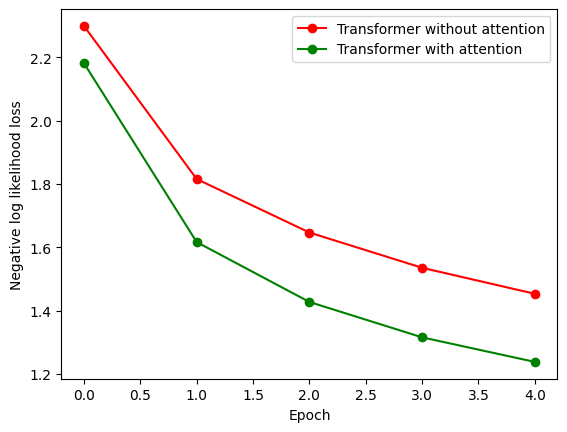

In [42]:
plt.xlabel("Epoch")
plt.ylabel("Negative log likelihood loss")
plt.plot(losses, 'ro-', label='Transformer without attention')
plt.plot(attn_losses, 'go-', label='Transformer with attention')
plt.legend()
plt.show()

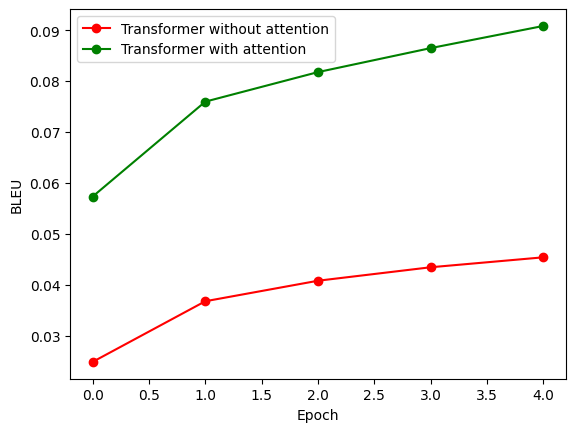

In [43]:
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.plot(metrics, 'ro-', label='Transformer without attention')
plt.plot(attn_metrics, 'go-', label='Transformer with attention')
plt.legend()
plt.show()

### Evaluation Results

Print bleu results on validation set for all the models

In [40]:
print("BLEU results on validation set:")
print(f"\tfor Dictionary-based Detection and Removal of Toxic Words: {rm_bleu}")
print("\tfor Dictionary-based Detection of Toxic Words and Replacement by "
      f"WordNet Synonyms: {wn_syn_bleu}")
print("\tDictionary-based Detection of Toxic Words and Replacement by "
      f"RoBERTa Synonyms: {bert_syn_bleu}")
print(f"\tfor GRU-based transformer: {trans_bleu}")
print(f"\tfor transformer with attention: {attn_trans_bleu}")

BLEU results on validation set:
	for Dictionary-based Detection and Removal of Toxic Words: 0.08477326112878693
	for Dictionary-based Detection of Toxic Words and Replacement by WordNet Synonyms: 0.0946853252415241
	Dictionary-based Detection of Toxic Words and Replacement by RoBERTa Synonyms: 0.08951501548290253
	for GRU-based transformer: 0.04540788705556608
	for transformer with attention: 0.04540788705556608


### Predictions

Print detoxed texts by the models

In [41]:
for index, row in val[:3].iterrows():
    ref = word_tokenize(row['reference'])
    tran = word_tokenize(row['translation'])
    print(f"Reference: \"{' '.join(ref)}\"")
    print(f"Translation: \"{' '.join(tran)}\"")
    print(f"rm_model: \"{' '.join(rm_model.detox(ref))}\"")
    print(f"wn_syn_model: \"{' '.join(wn_syn_model.detox(ref))}\"")
    print(f"bert_syn_model: \"{' '.join(bert_syn_model.detox(ref))}\"")
    print(f"trans_model: \"{' '.join(trans_model.detox(ref))}\"")
    print(f"attn_trans_model: \"{' '.join(attn_trans_model.detox(ref))}\"\n")

Reference: "You 're arrogant . You have the sickness that elites have had - throughout history in their literal , and in some cases figurative , ivory towers ."
Translation: "you are overwhelmed by the disease that elites have always been , - during history in your literal or metaphorical tower of ivory ."
rm_model: "'re have the sickness elites have throughout in literal and in cases figurative ivory towers"
wn_syn_model: "'re chesty have the sickness elites have have throughout account in literal and in about cases figurative ivory towers"
bert_syn_model: "These 're bel ' ' have the sickness  that elites have  esp oused throughout  Europe in  literal literal  representations and in  some cases figurative  literal ivory towers .'"
trans_model: "you re a dangerous and you re in the middle of the world"
attn_trans_model: "you re arrogant in the dictionary with the street and in the dictionary"

Reference: "Goddamn Variety had to print the story before I got the rights !"
Translation: "t